In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
%%capture
! pip install pytdc

In [4]:
%%capture
! pip install trl

In [5]:
import safe as sf
import datamol as dm
import torch
import numpy as np
from tqdm.auto import tqdm
from safe import SAFEDesign
from tdc import Oracle
from tdc import Evaluator
from safe.trainer.model import SAFEDoubleHeadsModel
from safe.tokenizer import SAFETokenizer
from random import choices
from trl import AutoModelForCausalLMWithValueHead, PPOConfig, PPOTrainer, create_reference_model

In [6]:
BATCH_SIZE = 64

In [7]:

def train(ppo_config, generation_kwargs, model, tokenizer, oracle, prefix=None, n_episodes=100):
    safe_encoder = sf.SAFEConverter()
    model_ref = create_reference_model(model)
    config = PPOConfig(**ppo_config)

    diversity_evaluator = Evaluator(name = 'Diversity')
    uniqueness_evaluator = Evaluator(name = 'Uniqueness')

    ppo_trainer = PPOTrainer(config, model, model_ref, tokenizer)
    if isinstance(prefix, str):
        
        encoded_fragment = safe_encoder.encoder(
                        prefix,
                        canonical=False,
                        randomize=True,
                        constraints=None,
                        allow_empty=True,
                    )        
        prefix = encoded_fragment.rstrip(".") + "."
        
    if prefix is None:
        prefix = ""
    
    if isinstance(prefix, str):
        prefix = [prefix]

    batch_size = ppo_config.get("batch_size", 32)
    if len(prefix) < batch_size:
        prefix = choices(prefix, k=batch_size)
    
    for episode in tqdm(range(n_episodes)): 
        game_data =  dict()
        game_data["query"] = prefix
        batch = tokenizer([tokenizer.bos_token+x for x in prefix], return_tensors="pt", add_special_tokens=False).to(model.pretrained_model.device)
        query_tensor = batch["input_ids"]
        response_tensor = ppo_trainer.generate([item for item in query_tensor], return_prompt=False, **generation_kwargs)
        decoded_safe_mols = tokenizer.batch_decode(response_tensor, skip_special_tokens=True)

        decoded_smiles = [
            sf.decode(x,
                    as_mol=False,
                    fix=True,
                    remove_added_hs=True,
                    canonical=True,
                    ignore_errors=True,
                    remove_dummies=True,
                ) for x in decoded_safe_mols
            ]
        game_data["response"] = decoded_safe_mols
        rewards = np.zeros(len(decoded_smiles))
        valid_position = []
        valid_smiles = []
        try:
            valid_position, valid_smiles = zip(*[(i, x) for i, x in enumerate(decoded_smiles) if x is not None])
            valid_smiles = list(valid_smiles)
            batch_reward = oracle(list(valid_smiles))
            rewards[np.asarray(valid_position)] = batch_reward
        except:
            pass
    
        rewards = torch.from_numpy(rewards).to(device=model.pretrained_model.device)
        rewards = [item for item in rewards]
        stats = ppo_trainer.step([_ for _ in query_tensor], [_ for _ in response_tensor], rewards)
        stats["validity"] = (len(valid_position) / BATCH_SIZE)
        if len(valid_smiles) > 0:
            stats["uniqueness"]  = uniqueness_evaluator(list(valid_smiles))
            stats["diversity"]  = diversity_evaluator(list(valid_smiles))
        ppo_trainer.log_stats(stats, game_data, rewards)
    return ppo_trainer, model

In [8]:
oracle = Oracle(name = 'DRD2')

Found local copy...


In [9]:
model_path = SAFEDesign._DEFAULT_MODEL_PATH
safe_tokenizer = SAFETokenizer.load(os.path.join(model_path, 'tokenizer.json'))
safe_model = SAFEDoubleHeadsModel.from_pretrained(model_path)

In [10]:
tokenizer = safe_tokenizer.get_pretrained()
model = AutoModelForCausalLMWithValueHead(safe_model)
model.is_peft_model = False

In [11]:
%%capture
! pip install wandb

In [12]:
ppo_config = {
    "batch_size": BATCH_SIZE, 
    "log_with":"wandb", 
    "model_name": "safe", 
    "tracker_project_name":"safe-drd2",
    "vf_coef": 0.2,
    "learning_rate": 1e-4,
}

generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.pad_token_id,
    "bos_token_id": tokenizer.bos_token_id,
    "eos_token_id": tokenizer.eos_token_id,
    "max_new_tokens": 100,
}


In [13]:
tokenizer = safe_tokenizer.get_pretrained()
model = AutoModelForCausalLMWithValueHead(safe_model)
model.is_peft_model = False

In [14]:
%env WANDB_SILENT=True
%env WANDB_LOG_MODEL=end
%env WANDB_WATCH=all
%env WANDB_PROJECT=safe-gpt2-drd2
%env WANDB_NAME=safe-gpt2

env: WANDB_SILENT=True
env: WANDB_LOG_MODEL=end
env: WANDB_WATCH=all
env: WANDB_PROJECT=safe-gpt2-drd2
env: WANDB_NAME=safe-gpt2


In [15]:
import wandb
wandb.finish()

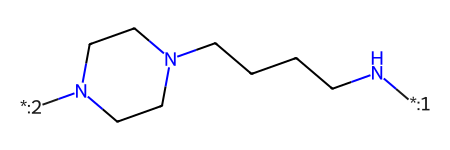

In [16]:
drd2_scaffold = "[*:2]N1CCN(CC1)CCCCN[*:1]"
dm.to_mol(drd2_scaffold)

In [17]:
designer = SAFEDesign.load_default()
generated = designer.scaffold_decoration(drd2_scaffold, do_not_fragment_further=True, add_dot=True)

In [18]:
%%wandb

trainer, trained_model = train(ppo_config, generation_kwargs, model, tokenizer, oracle, prefix=drd2_scaffold, n_episodes=100)

fatal: No names found, cannot describe anything.


  0%|          | 0/100 [00:00<?, ?it/s]

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
